In [84]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
from statsmodels.datasets import get_rdataset
from theano import tensor as tt
import pymc3 as pm

In [8]:
blue, *_ = sns.color_palette()
SEED = 5132290 #from random.org
np.random.seed(SEED)
N = 20
K = 30
alpha = 2.
P0 = sp.stats.norm


In [9]:
#Draw samples from the stick breaking process
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:,0] = beta[:,0]
w[:,1:] = beta[:,1:] * (1 - beta[:, :-1]).cumprod(axis=1)
omega = P0.rvs(size=(N,K))
x_plot = np.linspace(-3, 3, 200)
sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

In [10]:
beta.shape, w.shape, sample_cdfs.shape, omega.shape,np.less.outer(omega, x_plot).sum(axis=1).shape

((20, 30), (20, 30), (20, 200), (20, 30), (20, 200))

In [11]:
beta.cumprod(axis=1).shape, sample_cdfs[1:].T.shape

((20, 30), (200, 19))

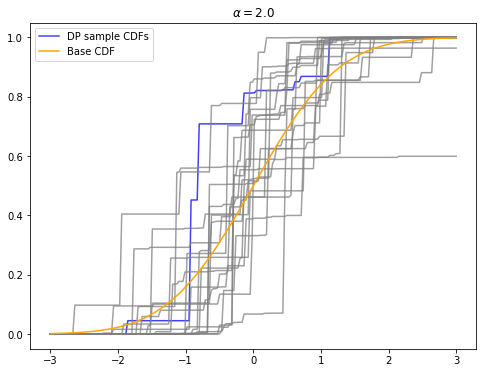

In [12]:
#Plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_plot, sample_cdfs[0], c='blue', alpha=0.75, label='DP sample CDFs')
ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75)
ax.plot(x_plot, P0.cdf(x_plot), c='orange', label='Base CDF')
ax.set_title(r'$\alpha={}$'.format(alpha))
ax.legend(loc=2)

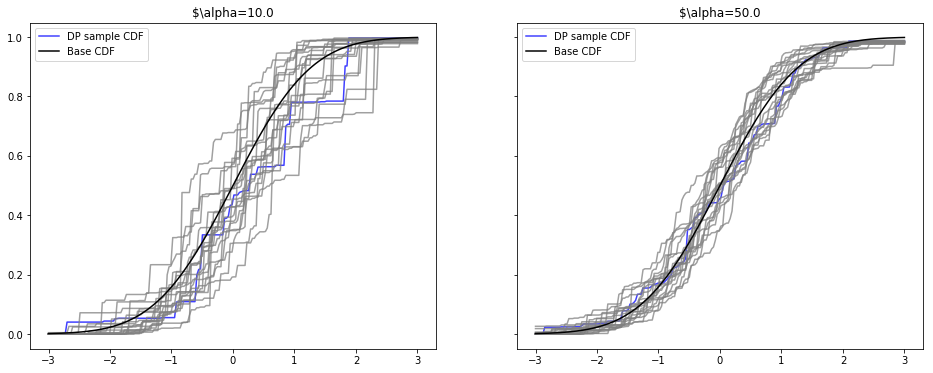

In [20]:
def create_data(alpha, K, x_plot):
    beta = sp.stats.beta.rvs(1, alpha, size=(N,K))
    w = np.empty_like(beta)
    w[:, 0] = beta[:, 0]
    w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)
    omega = P0.rvs(size=(N,K))
    sample_cdfs=(w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)
    return sample_cdfs, P0

fig, (l_ax, r_ax) = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(16,6))
sample_cdfs, P0 = create_data(alpha=10.,K=50, x_plot=x_plot)
l_ax.plot(x_plot, sample_cdfs[0], color='blue', alpha=0.75, label='DP sample CDF')
l_ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75)
l_ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF')
l_ax.set_title(r'$\alpha={}'.format(10.))
l_ax.legend(loc=2)

sample_cdfs, P0 = create_data(alpha=50.,K=200, x_plot=x_plot)
r_ax.plot(x_plot, sample_cdfs[0], color='blue', alpha=0.75, label='DP sample CDF')
r_ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75)
r_ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF')
r_ax.set_title(r'$\alpha={}'.format(50.))
r_ax.legend(loc=2)



### Dirichlet process mixtures
$$x | \theta \sim \mathcal{N}(\theta,0.3)$$

In [22]:
N = 5
K = 30
alpha = 2.
P0 = sp.stats.norm
f = lambda x, theta: sp.stats.norm.pdf(x, theta, 0.3)

In [25]:
beta = sp.stats.beta.rvs(1, alpha, size=(N,K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)
theta = P0.rvs(size=(N, K))
dpm_pdf_components = f(x_plot[np.newaxis, np.newaxis, :], theta[..., np.newaxis])
dpm_pdfs = (w[..., np.newaxis] * dpm_pdf_components).sum(axis=1)



[]

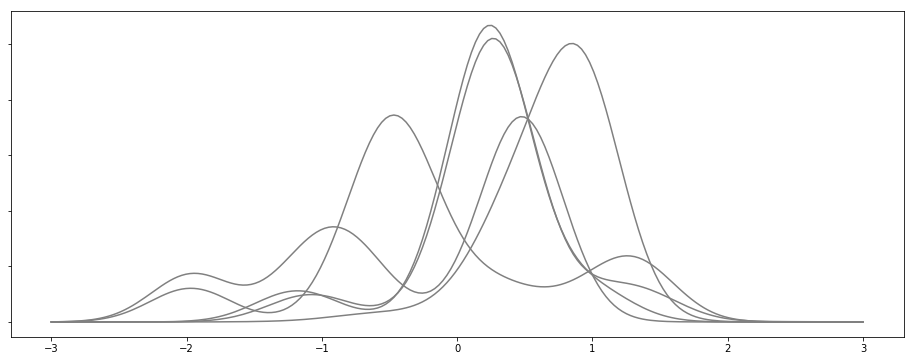

In [28]:
#Plot, the DPM which is used as input signal to model/approximate
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(x_plot, dpm_pdfs.T, c='gray')
ax.set_yticklabels([])

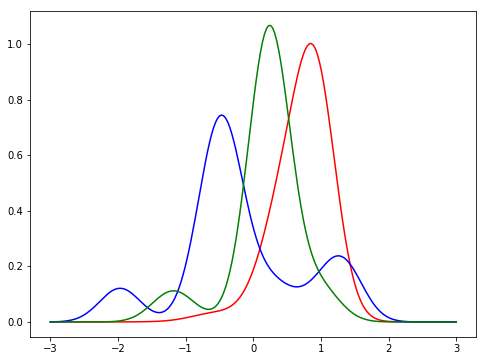

In [41]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_plot, dpm_pdfs[0], c='red')
ax.plot(x_plot, dpm_pdfs[1], c='blue')
ax.plot(x_plot, dpm_pdfs[2], c='green')


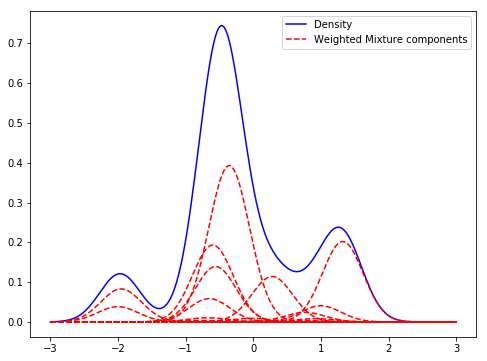

In [38]:
#Pick a single mixture [1] and decompose it into its individual (weighted) mixture components
fig, ax = plt.subplots(figsize=(8,6))
ix = 1
ax.plot(x_plot, dpm_pdfs[ix], c='blue', label='Density')
#Primary mixture component
#ax.plot(x_plot, (w[..., np.newaxis] * dpm_pdf_components)[ix, 0], 
#        '--', c='orange', label='Mixture components (weighted)' )
ax.plot(x_plot, (w[..., np.newaxis] * dpm_pdf_components)[ix].T, 
        '--', c='red', label='Weighted Mixture components')
ax.legend(loc=1)

### Old Faithful geyser in Yellowstone National Park
Estimate the density of waiting times between eruptions

In [45]:
of_df = get_rdataset('faithful', cache=True).data[['waiting']]
# Standardize the waiting time. Subtract the mean and divide by the standard deviation
of_df['std_waiting'] = (of_df.waiting - of_df.waiting.mean())/of_df.waiting.std()
of_df.head()

,waiting,std_waiting
0,79,0.596025
1,54,-1.242890
2,74,0.228242
3,62,-0.654437
4,85,1.037364


Text(0,0.5,'Number of eruptions')

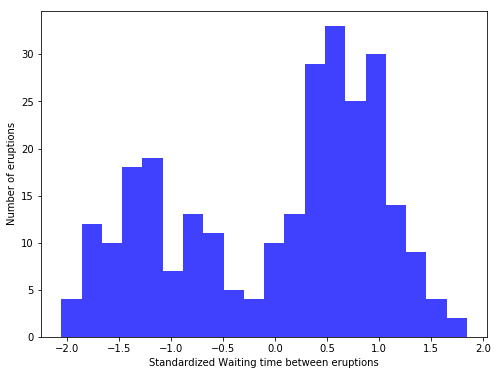

In [52]:
fig, ax = plt.subplots(figsize=(8,6))
n_bins = 20
ax.hist(of_df.std_waiting, bins=n_bins, color='blue', lw=0, alpha=0.75);
ax.set_xlabel('Standardized Waiting time between eruptions')
ax.set_ylabel('Number of eruptions')


### Model

In [81]:
%%latex
\begin{align}
\alpha \sim \Gamma(1,1) \\
\beta_1...\beta_K \sim \beta(1, \alpha) \\
w_i = \beta_i \prod_{j=1}^{i-1}(1 - \beta_j) \\
\lambda_1...\lambda_K \sim U(0,5) \\
\tau_1...\tau_K \sim \Gamma(1,1) \\
\mu_i \Bigm|  \lambda_i, \tau_i \sim \mathcal{N}(0, (\lambda_i \tau_i)^{-1})\\
x \Bigm| w_i, \lambda_i, \tau_i, \mu_i \sim \sum_{i=1}^{K} w_i \mathcal{N}(\mu_i, (\lambda_i \tau_i)^{-1})
\end{align}

<IPython.core.display.Latex object>

In [83]:
N = of_df.shape[0]
K = 30
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1-beta)[:-1]])
    return beta * portion_remaining


In [85]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))
    lambda_ = pm.Uniform('lambda_', 0, 5, shape=K)
    tau = pm.Gamma('tau', 1., 1., shape=K)
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_*tau, observed=of_df.std_waiting.values)
  

In [86]:
with model:
    trace = pm.sample(2000, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:21<00:00,  6.56it/s]C:\Anaconda3\envs\stpy35\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.899634074576, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
C:\Anaconda3\envs\stpy35\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 153 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



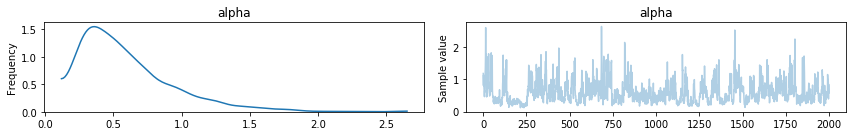

In [87]:
with model:
    pm.traceplot(trace, varnames=['alpha'])

Text(0,0.5,'Mixture weight')

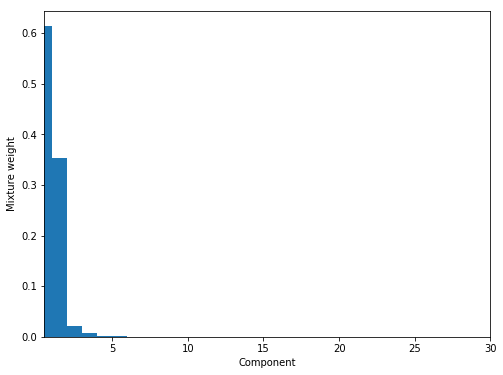

In [92]:
#Plot
fig, ax = plt.subplots(figsize=(8,6))
plot_w = np.arange(K) + 1
ax.bar(plot_w-0.5, trace['w'].mean(axis=0), width=1., lw=0)
ax.set_xlim(0.5, K)
ax.set_xlabel('Component')
ax.set_ylabel('Mixture weight')

In [93]:
#Posterior density estimates
post_pdf_contribs = sp.stats.norm.pdf(np.atleast_3d(x_plot), 
                                      trace['mu'][:, np.newaxis, :],
                                     1./np.sqrt(trace['lambda_']*trace['tau'])[:, np.newaxis, :])
post_pdfs = (trace['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)
post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)


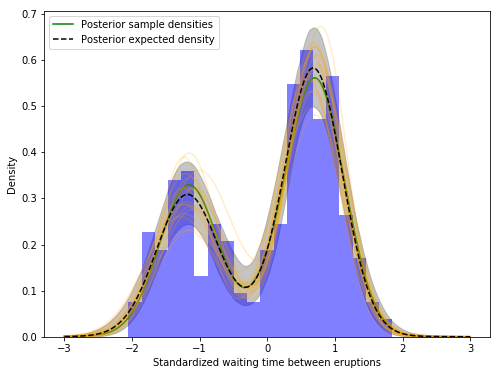

In [100]:
fig, ax = plt.subplots(figsize=(8,6))
nbins=20
ax.hist(of_df.std_waiting.values, bins=nbins, normed=True, color='blue', lw=0, alpha=0.5)
ax.fill_between(x_plot, post_pdf_low, post_pdf_high, color='gray', alpha=0.45)
ax.plot(x_plot, post_pdfs[0], c='green', label='Posterior sample densities')
#one every 100
ax.plot(x_plot, post_pdfs[::100].T, c='orange', alpha=0.2)
ax.plot(x_plot, post_pdfs.mean(axis=0), '--', c='k', label='Posterior expected density')
ax.set_xlabel('Standardized waiting time between eruptions')
ax.set_ylabel('Density')
ax.legend(loc=2)


In [103]:
post_pdfs.shape, plot_w.shape, 

((2000, 200),
 (30,),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]))

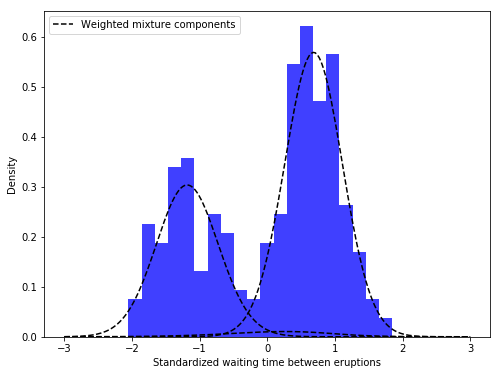

In [113]:
#Break these into the constituent components
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(of_df.std_waiting.values, bins=nbins,normed=True, color='blue', lw=0, alpha=0.75)
#Only 3 major components are plotted
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0)[:,:3], 
        '--', c='k', label='Weighted mixture components')
ax.set_xlabel('Standardized waiting time between eruptions')
ax.set_ylabel('Density')
ax.legend(loc=2)

## DP using a Poisson (Discrete) parameteric component distribution
Density of sunspots per year

In [116]:
sunspot_df = get_rdataset('sunspot.year', cache=True).data
sunspot_df.head()

,time,sunspot.year
0,1700,5.0
1,1701,11.0
2,1702,16.0
3,1703,23.0
4,1704,36.0


### The Model

In [132]:
%%latex
\begin{align}
\alpha \sim \Gamma(1,1) \\
\beta_1...\beta_K \sim \beta(1, \alpha) \\
w_i = \beta_i \prod_{j=1}^{i-1}(1-\beta_j)\\
\lambda_i \sim U(0,300)\\
x \space \Big| \space \lambda_i, w_i \sim \sum_{i=1}^{K} w_i Pois(\lambda_i) 
\end{align}

<IPython.core.display.Latex object>

In [127]:
K = 50
N = sunspot_df.shape[0]
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))
    mu = pm.Uniform('mu', 0, 300, shape=K)
    x = pm.Mixture('obs', w, pm.Poisson.dist(mu), observed=sunspot_df['sunspot.year'])
    

In [130]:
with model:
    trace = pm.sample(2000, step=pm.Metropolis(), tune=2000, random_seed=SEED)
    

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:35<00:00, 111.19it/s]


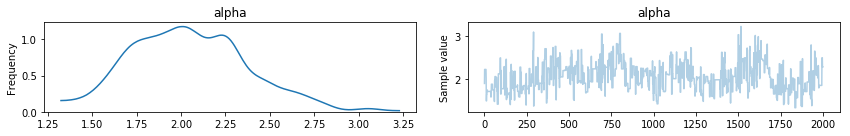

In [131]:
with model:
    pm.traceplot(trace, varnames=['alpha'])

Text(0,0.5,'Density')

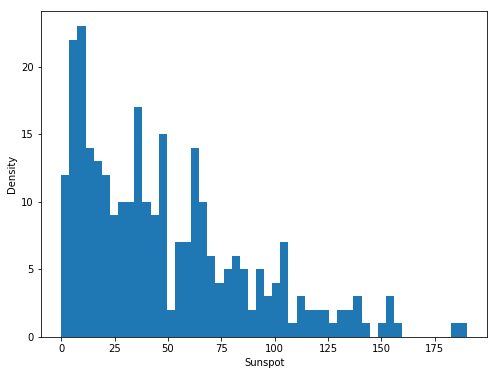

In [139]:
#Plot to see the most important contributors
#Based on the alpha value concentration between 1.25 and 3,
#in comparison to Old Faithful, there should be more significant contributors
#Remember the heuristic K = alpha * log N, or 5*alpha +2
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(sunspot_df['sunspot.year'].values, bins=50)
ax.set_xlabel('Sunspot')
ax.set_ylabel('Density')

Text(0,0.5,'Mixture Weight')

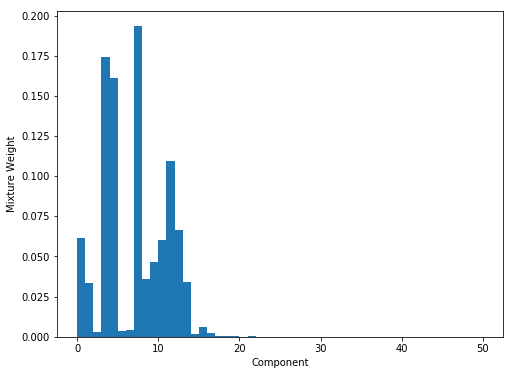

In [142]:
fig, ax = plt.subplots(figsize=(8,6))
plot_w = np.arange(K) + 1
ax.bar(plot_w-0.5, trace['w'].mean(axis=0), width=1.,lw=0)
ax.set_xlabel('Component')
ax.set_ylabel('Mixture Weight')
#Notice that there at least 15 non-trivial contributing components

In [147]:
#Plot the fitted density model
x_plot = np.arange(250)
pmf_contribs = sp.stats.poisson.pmf(np.atleast_3d(x_plot), 
                                   trace['mu'][:, np.newaxis, :])
#pmf_contribs.shape, N, K, trace['w'].shape, np.atleast_3d(x_plot)

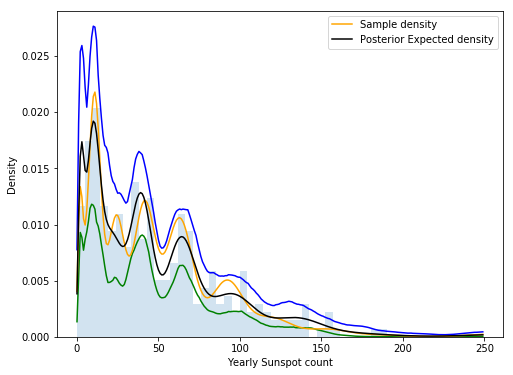

In [166]:
pmfs = (trace['w'][:, np.newaxis, :] * pmf_contribs).sum(axis=-1)
pmfs_lo, pmfs_hi = np.percentile(pmfs, [2.5, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(8,6))
ax.hist(sunspot_df['sunspot.year'].values, normed=True, bins=40,alpha=0.2, )
ax.plot(x_plot, pmfs_lo, c='green')
ax.plot(x_plot, pmfs_hi, c='blue')
ax.plot(x_plot, pmfs[0], c='orange', label='Sample density')
ax.plot(x_plot, pmfs.mean(axis=0), c='k', label='Posterior Expected density')
ax.set_xlabel('Yearly Sunspot count')
ax.set_ylabel('Density')
ax.legend(loc=1)

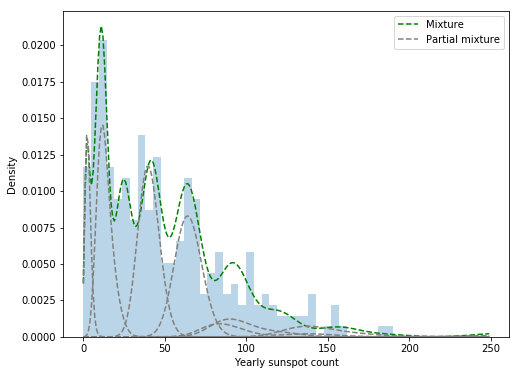

In [181]:
#Decomposing to weighted contributing components
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(sunspot_df['sunspot.year'].values, bins=40, normed=True, alpha=0.3)
ax.plot(x_plot, pmfs[:5].mean(axis=0), '--', c='green', label='Mixture')
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * pmf_contribs).mean(axis=0)[:,:10], 
        '--', c='gray', label='Partial mixture')
ax.set_xlabel('Yearly sunspot count')
ax.set_ylabel('Density')
ax.legend(loc=1)

In [202]:
with model:
    ppc = pm.sample_ppc(trace, 1000)
    


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 807.06it/s]


(array([ 0.01528167,  0.01055163,  0.00782276,  0.00745891,  0.00418427,
         0.00327464,  0.00163732,  0.00127347,  0.0007277 ,  0.00036385]),
 array([   0.  ,   19.02,   38.04,   57.06,   76.08,   95.1 ,  114.12,
         133.14,  152.16,  171.18,  190.2 ]),
 <a list of 10 Patch objects>)

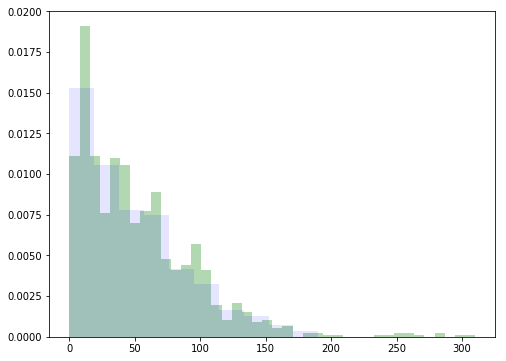

In [203]:

fig, ax = plt.subplots(figsize=(8,6))
#ax.plot(x_plot, ppc['obs'])
ax.hist(ppc['obs'], bins=40, normed=True,alpha=0.3, color='green')
ax.hist(sunspot_df['sunspot.year'].values, normed=True, alpha=0.1,color='blue')

In [205]:
sunspot_df['sunspot.year'].max(), sunspot_df['sunspot.year'].min(), sunspot_df['time'].max(),sunspot_df['time'].min(), 

(190.19999999999999, 0.0, 1988, 1700)

In [207]:
len(sunspot_df)

289

(0.30482460697868363,
 2.9269917949770891e-14,
 array([  6.14418330e-02,   3.34010953e-02,   2.94303739e-03,
          1.74440743e-01,   1.60960393e-01,   3.44935945e-03,
          4.48441833e-03,   1.93389943e-01,   3.60778577e-02,
          4.62905091e-02,   6.05134643e-02,   1.09371127e-01,
          6.65264167e-02,   3.38218910e-02,   1.98325223e-03,
          6.10957590e-03,   2.09193889e-03,   7.03610346e-04,
          6.41241416e-04,   5.94529447e-04,   1.40965777e-04,
          4.63360162e-04,   1.26502326e-05,   6.41573477e-05,
          4.65863317e-05,   7.25215519e-06,   8.83545662e-06,
          8.60546463e-06,   7.42792880e-06,   2.96328650e-07,
          8.92973453e-07,   1.59657309e-06,   2.77689479e-07,
          2.17813115e-07,   1.30567476e-07,   2.38905077e-07,
          4.17264373e-08,   1.38368280e-07,   2.08275283e-08,
          2.53870872e-08,   1.67336252e-08,   1.46558982e-08,
          2.68614768e-09,   8.54839118e-09,   3.40604132e-10,
          3.12192825e-1

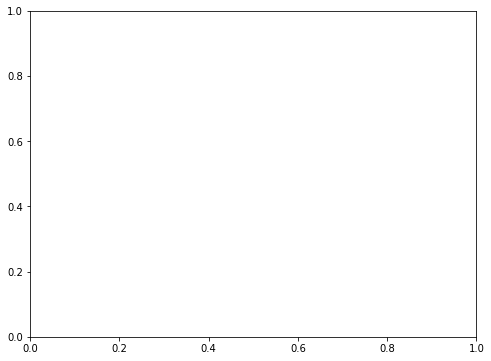

In [218]:
fig, ax = plt.subplots(figsize=(8,6))
#ax.plot(sunspot_df['time'], sunspot_df['sunspot.year'])
trace['w'].max(), trace['w'].min(), trace['w'].mean(axis=0)